## 1. Import libraries and dataset

Download [`stock-time-series` dataset from kaggle](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error

# Options: 'Open', 'High', 'Low', 'Close'
price_type = 'Close'
# E.g. 2016 and before
training_year = '2016'
# E.g. 2017 and after
test_year = '2017'

dataset = pd.read_csv('time-stock-series/AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

training_set = dataset[:training_year].iloc[:,1:2].values
test_set = dataset[test_year:].iloc[:,1:2].values

# Print example output of dataset
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


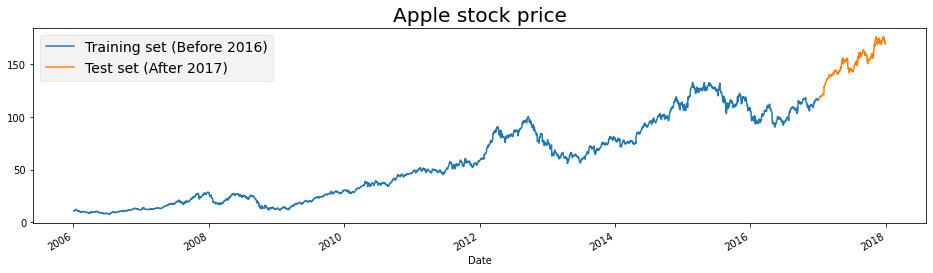

In [2]:
# Display graph to see the training and test data
dataset[price_type][:training_year].plot(figsize=(16,4),legend=True)
dataset[price_type][test_year:].plot(figsize=(16,4),legend=True)

plt.style.use('fivethirtyeight')
plt.legend([f'Training set (Before {training_year})', f'Test set (After {test_year})'])
plt.title('Apple stock price')
plt.show()

## 2. Scale training and test dataset

In [3]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_training_set = sc.fit_transform(training_set)

# Create a data structure with 60 timestamps + 1 output
# For each element of training set, we have 60 previous training set elements 
x_train = []
y_train = []
ts_size = 60

for i in range(ts_size, len(training_set)):
    x_train.append(scaled_training_set[i-ts_size:i,0])
    y_train.append(scaled_training_set[i,0])

x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshaping for efficient modelling
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## 3a. Create the LSTM model

[Read here on Dropout regularisation in RNN](https://adriangcoder.medium.com/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b)

In [9]:
model = Sequential()

# L1: LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

# L2: LSTM
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# L3: LSTM
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# L4: LSTM
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# L5: Output layer to "dense" into final outputs
model.add(Dense(units=1))

# Compile with the descent algorithm and loss function
model.compile(optimizer='rmsprop', loss='mean_squared_error')

## 3b. Train the LSTM model

In [10]:
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
85/85 [==============================] - 43s 131ms/step - loss: 0.0348
Epoch 2/25
85/85 [==============================] - 12s 138ms/step - loss: 0.0084
Epoch 3/25
85/85 [==============================] - 15s 173ms/step - loss: 0.0066
Epoch 4/25
85/85 [==============================] - 20s 238ms/step - loss: 0.0056
Epoch 5/25
85/85 [==============================] - 18s 213ms/step - loss: 0.0054
Epoch 6/25
85/85 [==============================] - 14s 168ms/step - loss: 0.0042
Epoch 7/25
85/85 [==============================] - 15s 181ms/step - loss: 0.0044
Epoch 8/25
85/85 [==============================] - 12s 146ms/step - loss: 0.0035
Epoch 9/25
85/85 [==============================] - 16s 192ms/step - loss: 0.0030
Epoch 10/25
85/85 [==============================] - 17s 196ms/step - loss: 0.0029
Epoch 11/25
85/85 [==============================] - 19s 224ms/step - loss: 0.0031
Epoch 12/25
85/85 [==============================] - 16s 183ms/step - loss: 0.0025
Epoch 13/25
8

## 3c. Display predictions

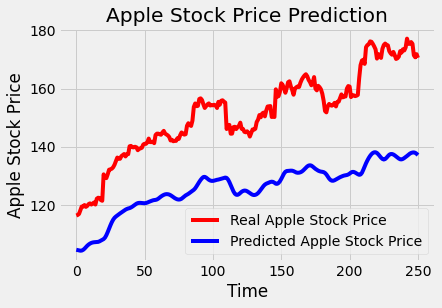

The root mean squared error is 26.399878770526666.


In [30]:
def plot_predictions(x_test, y_pred):
    plt.plot(x_test, color='red',label='Real Apple Stock Price')
    plt.plot(y_pred, color='blue',label='Predicted Apple Stock Price')
    plt.title('Apple Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Apple Stock Price')
    plt.legend()
    plt.show()


def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

# Can be reused later
inputs = dataset_total[len(dataset) - len(test_set) - ts_size:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

# Prepare for prediction
x_test = []

for i in range(ts_size, len(test_set) + ts_size):
    x_test.append(inputs[i-ts_size:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_pred = model.predict(x_test)
y_pred = sc.inverse_transform(y_pred)

plot_predictions(test_set, y_pred)
return_rmse(test_set, y_pred)

## 4a. Create the GRU model

In [31]:
model = Sequential()

# L1: GRU
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

# L2: GRU
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

# L3: GRU
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

# L4: GRU
model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2))

# L5: Output layer to "dense" into final outputs
model.add(Dense(units=1))

# Compile with the descent algorithm and loss function
model.compile(optimizer='adam', loss='mean_squared_error')

## 4b. Train the GRU model

In [32]:
model.fit(x_train, y_train, epochs=25, batch_size=150)

Epoch 1/25
19/19 [==============================] - 25s 413ms/step - loss: 0.1144
Epoch 2/25
19/19 [==============================] - 6s 329ms/step - loss: 0.0091
Epoch 3/25
19/19 [==============================] - 6s 314ms/step - loss: 0.0045
Epoch 4/25
19/19 [==============================] - 6s 307ms/step - loss: 0.0039
Epoch 5/25
19/19 [==============================] - 6s 323ms/step - loss: 0.0036
Epoch 6/25
19/19 [==============================] - 6s 306ms/step - loss: 0.0031
Epoch 7/25
19/19 [==============================] - 6s 310ms/step - loss: 0.0032
Epoch 8/25
19/19 [==============================] - 6s 320ms/step - loss: 0.0031
Epoch 9/25
19/19 [==============================] - 9s 466ms/step - loss: 0.0029
Epoch 10/25
19/19 [==============================] - 7s 360ms/step - loss: 0.0030
Epoch 11/25
19/19 [==============================] - 6s 335ms/step - loss: 0.0031
Epoch 12/25
19/19 [==============================] - 6s 320ms/step - loss: 0.0032
Epoch 13/25
19/19 [=====

## 4c. Display predictions

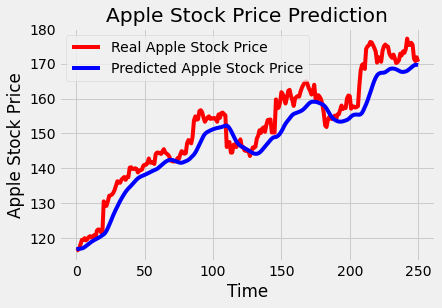

The root mean squared error is 5.367255921172781.


In [33]:
# Prepare for prediction
x_test = []

for i in range(ts_size, len(test_set) + ts_size):
    x_test.append(inputs[i-ts_size:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_pred = model.predict(x_test)
y_pred = sc.inverse_transform(y_pred)

plot_predictions(test_set, y_pred)
return_rmse(test_set, y_pred)